# CS 181: T2
### Christine Zhang

---

In [133]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from scipy.misc import logsumexp
import pandas as pd
from LogisticRegression import LogisticRegression
from GaussianGenerativeModel import GaussianGenerativeModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from scipy.stats import beta

In [152]:
class LogisticRegression:
    def __init__(self, eta, lambda_parameter):
        self.eta = eta
        self.lambda_parameter = lambda_parameter
    
    # Just to show how to make 'private' methods
    def __dummyPrivateMethod(self, input):
        return None

    # TODO: Implement this method!
    def fit(self, X, C):
        
        enc = preprocessing.OneHotEncoder()
        C_onehot = C.reshape(-1, 1)
        enc.fit(C_onehot)
        C_onehot = enc.transform(C_onehot).toarray()
        
        X = np.insert(X, 2, 1, axis=1)

        num_trials = 10000
        num_classes = 3
        self.num_classes = num_classes
        w_T = [[0,0,0]]*num_classes
        
#         for trial_count in [2000,4000,6000,8000,10000, 12000,14000,16000,18000,20000]:
        
        for each_trial in range(num_trials):

            final_softmax = []

            for index, datapoint in enumerate(X):

                numerator = []

                for class_val in range(num_classes):

                    z = np.exp(np.dot(w_T[class_val], X[index]))
                    numerator.append(z)

                z_all = np.exp(logsumexp(np.dot(w_T, X[index])))
                softmax = [i / z_all for i in numerator]

                final_softmax.append(softmax)

            delta = np.dot((final_softmax - np.array(C_onehot)).transpose(), X) 
#             + 2 * np.array(w_T) * lambda_parameter
            w_T = w_T - delta*eta

        self.X = X
        self.C = C
        self.w_T = w_T

#         sum_val = self.loglikelihood(X, C)
#         print (sum_val)
                            
        return 
    
    def loglikelihood (self, X, C):
        
        sum_val = 0
        
        for index, datapoint in enumerate(X):

            numerator = []

            for class_val in range(self.num_classes):

                z = np.exp(np.dot(self.w_T[class_val], X[index]))
                numerator.append(z)

            z_all = np.exp(logsumexp(np.dot(self.w_T, X[index])))
            softmax = [i / z_all for i in numerator]

            sum_val += - math.log(max(softmax)) 
            
        return sum_val + lambda_parameter * np.sum(self.w_T * self.w_T)
            

    # TODO: Implement this method!
    def predict(self, X_to_predict):
        
        X_to_predict = np.insert(X_to_predict, 2, 1, axis=1)
        Y = []
        
        num_classes = 3
        for index, datapoint in enumerate(X_to_predict):
            softmax = []
            for class_val in range(num_classes):
                z = np.dot(self.w_T[class_val], X_to_predict[index].transpose())
                softmax.append(z)
            Y.append(np.argmax(softmax))
        
        return np.array(Y)

    def visualize(self, output_file, width=2, show_charts=True):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min,
            y_max, .05))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))
        
        cMap = c.ListedColormap(['r','b','g'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap)
        plt.scatter(X[:, 0], X[:, 1], c=self.C, cmap=cMap, edgecolor="black")
        plt.savefig(output_file)
        if show_charts:
            plt.show()

In [156]:
eta = .00075
lambda_parameter = .001

In [161]:
class GaussianGenerativeModel:
    def __init__(self, isSharedCovariance=False):
        self.isSharedCovariance = isSharedCovariance

    # Just to show how to make 'private' methods
    def __dummyPrivateMethod(self, input):
        return None

    # TODO: Implement this method!
    def fit(self, X, Y):
        
        X_0 = [X[index] for index, val in enumerate(Y) if val == 0]    
        X_1 = [X[index] for index, val in enumerate(Y) if val == 1]  
        X_2 = [X[index] for index, val in enumerate(Y) if val == 2]              
        
        num_classes = 3
        mu_k = []
        
        for k in [X_0, X_1, X_2]:
            mu_k.append(sum(k)/len(k))
            
        sigma = []
        for k in [X_0, X_1, X_2]:
            k_1 = [i for [i,j] in k]
            k_2 = [j for [i,j] in k]
            sigma.append(np.cov(np.array(k).transpose()))
            
        if self.isSharedCovariance:
            sigma_final = np.array(sigma[0])*len(X_0)/len(X) + np.array(sigma[1])*len(X_1)/len(X) + np.array(sigma[2])*len(X_2)/len(X)
            sigma_final = [sigma_final, sigma_final, sigma_final]
            
        else:
            sigma_final = sigma
                        
        self.X = X
        self.Y = Y
        self.X_0 = X_0
        self.X_1 = X_1
        self.X_2 = X_2
        self.mu_k = mu_k
        self.sigma = sigma_final 
        
        sum_val = self.loglikelihood(X, Y)
        print (sum_val)
        
        return

    # TODO: Implement this method!
    def predict(self, X_to_predict):
        # The code in this method should be removed and replaced! We included it just so that the distribution code
        # is runnable and produces a (currently meaningless) visualization.
        
        Y = []
        for x in X_to_predict:
            pdf_0 = multivariate_normal.pdf(x, mean= self.mu_k[0], cov=self.sigma[0])
            pdf_1 = multivariate_normal.pdf(x, mean= self.mu_k[1], cov=self.sigma[1])
            pdf_2 = multivariate_normal.pdf(x, mean= self.mu_k[2], cov=self.sigma[2])
            Y.append(np.argmax([pdf_0, pdf_1, pdf_2]))
        
        return np.array(Y)
    
    def loglikelihood (self, X, Y):
        
        sum_val = 0
        
        for x in X:

            pdf_0 = multivariate_normal.pdf(x, mean= self.mu_k[0], cov=self.sigma[0])
            pdf_1 = multivariate_normal.pdf(x, mean= self.mu_k[1], cov=self.sigma[1])
            pdf_2 = multivariate_normal.pdf(x, mean= self.mu_k[2], cov=self.sigma[2])
            arg_max = np.argmax([pdf_0, pdf_1, pdf_2])
            if arg_max == 0:
                pi_k = len(self.X_0)/len(X)
            elif arg_max == 1:
                pi_k = len(self.X_1)/len(X)
            else:
                pi_k = len(self.X_2)/len(X)
            sum_val += - math.log(max([pdf_0, pdf_1, pdf_2])) - math.log(pi_k)
            
        return sum_val

    # Do not modify this method!
    def visualize(self, output_file, width=3, show_charts=True):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min,
            y_max, .05))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

        cMap = c.ListedColormap(['r','b','g'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap)
        plt.scatter(X[:, 0], X[:, 1], c=self.Y, cmap=cMap, edgecolor="black")
        plt.savefig(output_file)
        if show_charts:
            plt.show()

146.54953399119216


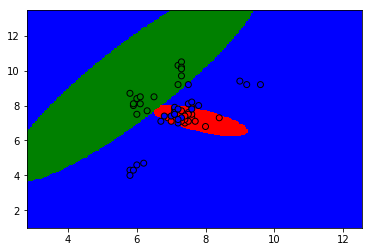

179.44843605006218


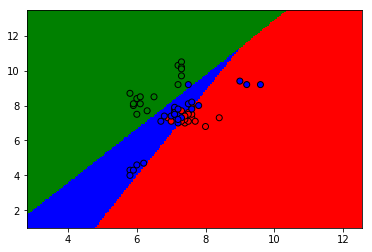

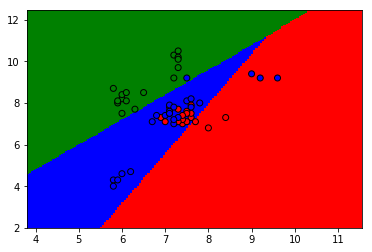

Test fruit predictions for Gaussian Model:
width 4 cm and height 11 cm: 1
width 8.5 cm and height 7 cm: 0
Test fruit predictions for Shared Covariance Gaussian Model:
width 4 cm and height 11 cm: 2
width 8.5 cm and height 7 cm: 0
Test fruit predictions for Linear Regression:
width 4 cm and height 11 cm: 2
width 8.5 cm and height 7 cm: 0


In [162]:
df = pd.read_csv("fruit.csv")
X = df[['width', 'height']].values
Y = (df['fruit'] - 1).values

nb1 = GaussianGenerativeModel(isSharedCovariance=False)
nb1.fit(X,Y)
nb1.visualize("generative_result_separate_covariances.png")

nb2 = GaussianGenerativeModel(isSharedCovariance=True)
nb2.fit(X,Y)
nb2.visualize("generative_result_shared_covariances.png")

lr = LogisticRegression(eta=eta, lambda_parameter=lambda_parameter)
lr.fit(X,Y)
lr.visualize('logistic_regression_result.png')

X_test = np.array([[4,11],[8.5,7]])
Y_nb1 = nb1.predict(X_test)
Y_nb2 = nb2.predict(X_test)
Y_lr = lr.predict(X_test)

print("Test fruit predictions for Gaussian Model:")
print("width 4 cm and height 11 cm: " + str(Y_nb1[0]))
print("width 8.5 cm and height 7 cm: " + str(Y_nb1[1]))

print("Test fruit predictions for Shared Covariance Gaussian Model:")
print("width 4 cm and height 11 cm: " + str(Y_nb2[0]))
print("width 8.5 cm and height 7 cm: " + str(Y_nb2[1]))

print("Test fruit predictions for Linear Regression:")
print("width 4 cm and height 11 cm: " + str(Y_lr[0]))
print("width 8.5 cm and height 7 cm: " + str(Y_lr[1]))

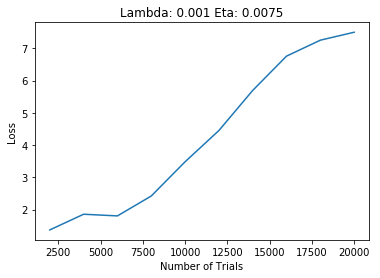

In [105]:
X_axis = [2000,4000,6000,8000,10000, 12000,14000,16000,18000,20000]
Loss = [1.37153633012,
1.85747571066,
1.8054442944,
2.42229751473,
3.48213674635,
4.45121881074,
5.69380132454,
6.75655536765,
7.25094776152,
7.49666469635]
plt.plot(X_axis, Loss)
plt.title('Lambda: %s Eta: %s'%(0.001, 0.0075))
plt.xlabel("Number of Trials")
plt.ylabel("Loss")
plt.show()

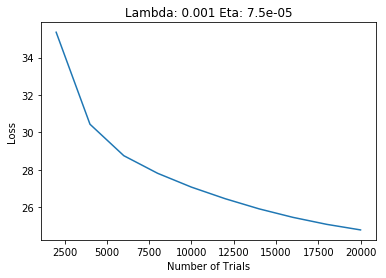

In [100]:
X_axis = [2000,4000,6000,8000,10000, 12000,14000,16000,18000,20000]
Loss = [35.3522357412,
30.4384268854,
28.7580211702,
27.8178225404,
27.0790900305,
26.459119071,
25.9185797535,
25.4650225943,
25.0909902639,
24.7936105426]
plt.plot(X_axis, Loss)
plt.title('Lambda: %s Eta: %s'%(0.001, 0.000075))
plt.xlabel("Number of Trials")
plt.ylabel("Loss")
plt.show()

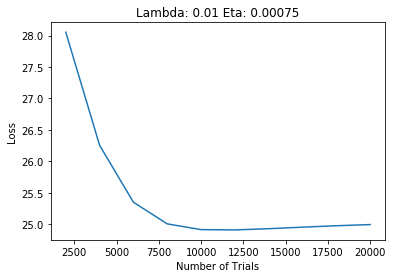

In [91]:
X_axis = [2000,4000,6000,8000,10000, 12000,14000,16000,18000,20000]
Loss = [28.0526018926,
26.2552390138,
25.3508944924,
25.0070333598,
24.9157815734,
24.9110830017,
24.9304864048,
24.9547681735,
24.9774535311,
24.9959956449]
plt.plot(X_axis, Loss)
plt.title('Lambda: %s Eta: %s'%(0.01, 0.00075))
plt.xlabel("Number of Trials")
plt.ylabel("Loss")
plt.show()

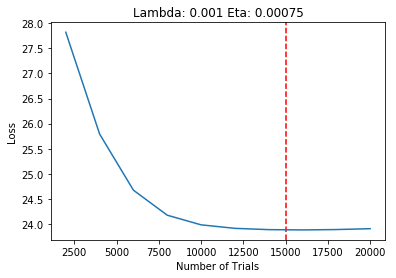

In [166]:
X_axis = [2000,4000,6000,8000,10000, 12000,14000,16000,18000,20000]
Loss = [27.8167885331,
25.7939320364,
24.6778966412,
24.1806249368,
23.9892778733,
23.9194582607,
23.8939031037,
23.8882579984,
23.8955312368,
23.9127459607]
plt.axvline(x=15000, color = "red", linestyle="--")
plt.plot(X_axis, Loss)
plt.title('Lambda: %s Eta: %s'%(0.001, 0.00075))
plt.xlabel("Number of Trials")
plt.ylabel("Loss")
plt.show()

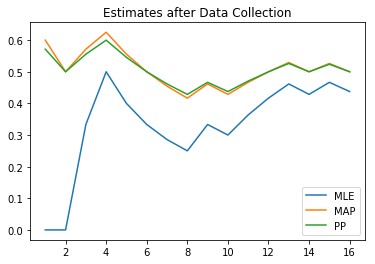

In [127]:
data = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
mle = [0,0,1/3,1/2,2/5,2/6,2/7,2/8,3/9,3/10,4/11,5/12,6/13,6/14,7/15,7/16]
map_vals = [3/5,3/6,4/7,5/8,5/9,5/10,5/11,5/12,6/13,6/14,7/15,8/16,9/17,9/18,10/19,10/20]
pp = [4/7,4/8,5/9,6/10,6/11,6/12,6/13,6/14,7/15,7/16,8/17,9/18,10/19,10/20,11/21,11/22]
plt.plot(data, mle)
plt.plot(data, map_vals)
plt.plot(data, pp)
plt.legend(["MLE", "MAP", "PP"])
plt.title("Estimates after Data Collection")
plt.show()

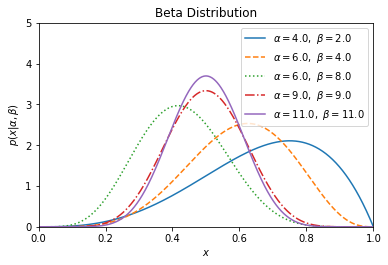

In [160]:
alpha_values = [4, 6, 6, 9, 11]
beta_values = [2, 4, 8, 9, 11]
linestyles = ['-', '--', ':', '-.', '-']
x = np.linspace(0, 1, 1002)[1:-1]

# plot the distributions
fig, ax = plt.subplots(figsize=(6, 3.75))

for a, b, ls in zip(alpha_values, beta_values, linestyles):
    dist = beta(a, b)

    plt.plot(x, dist.pdf(x), ls=ls,
             label=r'$\alpha=%.1f,\ \beta=%.1f$' % (a, b))

plt.xlim(0, 1)
plt.ylim(0, 5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\alpha,\beta)$')
plt.title('Beta Distribution')

plt.legend(loc=0)
plt.show()